**Color Mapper**
1. Provides a set of function for color space conversions between sRGB, CIE XYZ, LAB etc.
2. Provides a set of functions to compute the difference between 2 similar colors.


**Useful colormap functions to convert between different color spaces:**
- Convert from sRGB to linear sRGB (vice versa)
- Convert from linear sRGB to CIE XYZ (vice versa)
- Convert from CIE XYZ to CIE LAB (vice versa)
- Convert from CIE XYZ to sRGB


Python colormaps ref:
http://pydoc.net/pwkit/0.8.15/pwkit.colormaps/

In [17]:
import os
import numpy as np
import cv2 
import math
import matplotlib.pyplot as plt

**Color conversion functions**

In [18]:
# I don't quite understand where this value comes from, given the various
# Wikipedia values for D65, but this works.
CIELAB_D65 = np.asarray ([0.9505, 1., 1.0890])

X, Y, Z = range(3)
L, A, B = range(3)

# from Moreland:
_linsrgb_to_xyz = np.asarray ([[0.4124, 0.2126, 0.0193],
                               [0.3576, 0.7152, 0.1192],
                               [0.1805, 0.0722, 0.9505]])

# from Wikipedia, SRGB:
_xyz_to_linsrgb = np.asarray ([[3.2406, -0.9689, 0.0557],
                               [-1.5372, 1.8758, -0.2040],
                               [-0.4986, 0.0415, 1.0570]])


def srgb_to_linsrgb (srgb):
    """Convert sRGB values to physically linear ones. The transformation is
    uniform in RGB, so *srgb* can be of any shape.

    *srgb* values should range between 0 and 1, inclusively.

    """
    srgb = srgb/255.0
    gamma = ((srgb + 0.055) / 1.055)**2.4
    scale = srgb / 12.92
    return np.where (srgb > 0.04045, gamma, scale)

def linsrgb_to_srgb (linsrgb):
    """Convert physically linear RGB values into sRGB ones. The transform is
    uniform in the components, so *linsrgb* can be of any shape.

    *linsrgb* values should range between 0 and 1, inclusively.

    """
    # From Wikipedia, but easy analogue to the above.
    gamma = 1.055 * linsrgb**(1./2.4) - 0.055
    scale = linsrgb * 12.92
    linsrgb = np.where (linsrgb > 0.0031308, gamma, scale)
    linsrgb = linsrgb * 255.0
    return linsrgb


def linsrgb_to_xyz (linsrgb):
    """Convert linearized sRGB values (cf srgb_to_linsrgb) to CIE XYZ values.

    *linsrgb* should be of shape (*, 3). Values should range between 0 and 1
    inclusively. Return value will be of same shape.

    Returned XYZ values range between [0, 0, 0] and [0.9505, 1., 1.089].

    """
    return np.dot (linsrgb, _linsrgb_to_xyz)


def xyz_to_linsrgb(xyz): 
    """Convert CIE XYZ values to linearized sRGB values (cf srgb_to_linsrgb).

    *xyz* should be of shape (*, 3)

    Return value will be of same shape.

    """
    return np.dot(xyz,_xyz_to_linsrgb)

def xyz_to_cielab(xyz,refwhite=CIELAB_D65):
    """Convert CIE xyz color values to CIE L*a*b.
    *xyz* should be of shape (*,3). *refwhite* is the reference white value of,
    shape(3,)
    
    Return value will have same shape as *xyz*, but be in CIE L*a*b
    coordinates.
    """
    norm = xyz/refwhite
    pow = norm**0.333333333333333
    scale = 7.787037 * norm + 16./116
    mapped = np.where(norm >  0.008856, pow, scale)
    
    cielab = np.empty_like(xyz)
    cielab[...,L] = 116 * mapped[...,Y] - 16
    cielab[...,A] = 500 * (mapped[...,X] - mapped[...,Y])
    cielab[...,B] = 200 * (mapped[...,Y] - mapped[...,Z])
    
    return cielab


    
def cielab_to_xyz(cielab,refwhite=CIELAB_D65):
    """Convert CIE L*a*b* color values to CIE XYZ,

    *cielab* should be of shape (*, 3). *refwhite* is the reference white
    value in the L*a*b* color space, of shape (3, ).

    Return value has same shape as *cielab*

    """
    def func (t):
        pow = t**3
        scale = 0.128419 * t -  0.0177129
        return np.where(t > 0.206897,pow,scale)
    
    xyz = np.empty_like(cielab)
    lscale = 1./116 * (cielab[...,L] + 16)
    xyz[...,X] = func(lscale + 0.002 * cielab[...,A])
    xyz[...,Y] = func(lscale)
    xyz[...,Z] = func(lscale - 0.005 * cielab[...,B])
    xyz *= refwhite
    return xyz


def srgb_to_cielab(srgb):
    linsrgb = srgb_to_linsrgb(srgb)
    xyz = linsrgb_to_xyz(linsrgb)
    cielab = xyz_to_cielab(xyz)
    return cielab
    
    
def test_color_conversions():
    testRGB = np.array([118,118,118])
    print("The value of 18% gray - sRGB: ", testRGB)
    
    testsRGB_linsRGB = srgb_to_linsrgb(testRGB)
    print("The value of 18% gray, sRGB - linear RGB: ", testsRGB_linsRGB)
    
    testlinsRGB_sRGB = linsrgb_to_srgb(testsRGB_linsRGB)
    print("The value of 18% gray, linear RGB - sRGB: ", testlinsRGB_sRGB)
    
    testlinsRGB_XYZ = linsrgb_to_xyz(testsRGB_linsRGB)
    print("The value of 18% gray - linear sRGB to CIE XYZ: ", testlinsRGB_XYZ)
    
    testlinsRGB_XYZ_LAB = xyz_to_cielab(testlinsRGB_XYZ)
    print("The value of 18% gray - CIE XYZ to CIE LAB: ", testlinsRGB_XYZ_LAB)
    
    testLAB_XYZ = cielab_to_xyz(testlinsRGB_XYZ_LAB)
    print("The value of 18% gray - CIE LAB to CIE XYZ: ", testLAB_XYZ)
    
    testXYZ_linsRGB = xyz_to_linsrgb(testLAB_XYZ)
    print("The value of 18% gray - CIE XYZ to linear RGB: ", testXYZ_linsRGB)
    
    testlinsRGB_sRGB = linsrgb_to_srgb(testXYZ_linsRGB)
    print("The value of 18% gray - linear RGB to sRGB: ", np.round(testlinsRGB_sRGB))

**Color math methods**

In [19]:
'''
Compute the transformation matrix (CCM) between True reference RGB values
and the obtained target values
'''
def compute_ColorCorrectionMatrix(refValues,targetValues):
    #Undo the gamma correction and convert sRGB to linear sRGB values
    linRefValues = srgb_to_linsrgb(refValues)
    linTargetValues = srgb_to_linsrgb(targetValues)
    
    ColorCorrectionMatrix = np.linalg.lstsq(linTargetValues,linRefValues,rcond=None)[0]
    return ColorCorrectionMatrix
    

'''
CIEDE2000 (Detla E) method implementation for finding difference between 
2 colors in the LAB color space
'''
def CIEDE2000(Lab_1,Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00
        

In [20]:
    print(CIEDE2000((50, 2.6772, -79.7751), (50, 0.0000, -82.7485)))
    print(CIEDE2000((50, 0, 0), (50.0000, -1, 2)))
    print(CIEDE2000((50, 2.5, 0), (73, 25, -18)))

2.0424596801565604
2.3668588191717523
27.14923130074626


In [10]:
srgb2cielab = np.array([255,255,255])
srgb2cielab = srgb_to_cielab(srgb2cielab)
print(srgb2cielab)

[100.   0.   0.]


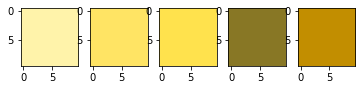

[95.27176529 -6.46717026 36.71520784]


In [26]:
#Define and draw the set standard of urine color code
code1 = np.array([255,243,170])
code2 = (255,228,100)
code3 = (255,226,77)
code4 = (136,119,37)
code5 = (194,142,0)
    
code1_swatch = np.full((10,10,3),code1,dtype = np.uint8) 
code2_swatch = np.full((10,10,3),code2,dtype = np.uint8) / 255.0
code3_swatch = np.full((10,10,3),code3,dtype = np.uint8) / 255.0
code4_swatch = np.full((10,10,3),code4,dtype = np.uint8) / 255.0
code5_swatch = np.full((10,10,3),code5,dtype = np.uint8) / 255.0
        
plt.subplot(1,5,1)
plt.imshow(code1_swatch)
plt.subplot(1,5,2)
plt.imshow(code2_swatch)
plt.subplot(1,5,3)
plt.imshow(code3_swatch)
plt.subplot(1,5,4)
plt.imshow(code4_swatch)
plt.subplot(1,5,5)
plt.imshow(code5_swatch)
plt.show()
    
code1_swatchCIE = srgb_to_cielab(code1)
print(code1_swatchCIE)
code2_swatch = np.full((10,10,3),code2,dtype = np.uint8) / 255.0
code3_swatch = np.full((10,10,3),code3,dtype = np.uint8) / 255.0
code4_swatch = np.full((10,10,3),code4,dtype = np.uint8) / 255.0
code5_swatch = np.full((10,10,3),code5,dtype = np.uint8) / 255.0